In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import sima

In [2]:
import sima as sim

In [3]:
sim.stica_approach = sima.segment.STICA(components=5)
stica_approach.append(sima.segment.SparseROIsFromMasks())
stica_approach.append(sima.)

In [100]:
couner = 0
startTime = time.time()
test = np.zeros([5000,1000],dtype="int")
for i in  np.nditer(test,order='F',op_flags=['writeonly']):
    i[...] = couner
    couner +=1
print couner
print (time.time()-startTime)

5000000
2.04154920578


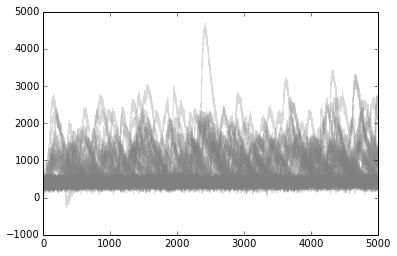

In [2]:
#code used for creation of set1 of simulated data

def alphaKernel (t, A,t_A,t_B):
    return np.float64(A*(np.exp(-t/t_A)-np.exp(-t/t_B)))

xMatrix = np.ndarray(shape=(5000,40),dtype='float32')
apList = []
for i in np.nditer(xMatrix,order='F',flags=['external_loop'],op_flags=['writeonly']):
    localAPlist = []
    xtest = np.repeat(400,5000.)
    xnoise = 80. * np.random.normal(size = xtest.size)
    xtest = xtest +xnoise
    apNumber = int(np.random.normal(loc=4,scale = 2)*3)
    
    for j in range(apNumber):
        xdata = np.arange(0,int(400*np.random.normal(loc=1,scale=0.3)),1.)
        y = (alphaKernel(xdata,np.random.normal(loc=5,scale=0.3) * 400,
                        30* np.random.normal(loc=4,scale=1),10*np.random.normal(loc=4,scale=1)))
        APposition = int(np.random.sample(size=1)* 5000)
        localAPlist.append(APposition)
        APend = APposition + y.size 
        if(APend > xtest.size):
            y.resize(xtest.size-APposition)
        xtest[APposition:APend] = xtest[APposition:APend] + y
        if (APend < 4999 and xtest[APend] - xtest[APend+1] > 80 ):
            corrector = np.arange(xtest[APend] - xtest[APend+1],0,-10)
            if(APend+ corrector.size > xtest.size):
                corrector.resize(xtest.size-APend)
            xtest[APend:APend+corrector.size] = xtest[APend:APend+corrector.size] + corrector
    i[...] = xtest
    plt.plot(xtest,'grey',alpha=0.3)
    apList.append(sorted(localAPlist))
plt.show()
np.savetxt('/home/maximilian/unistuff/paris_ens/cal_neuroim/simdata/set1',xMatrix,delimiter=',',fmt='%4.6f')

df = pd.DataFrame(apList)
df.to_csv('/home/maximilian/unistuff/paris_ens/cal_neuroim/simdata/apTimings.csv')

[1835.7959987054762, 2231.5499289338036, 2016.5688714369714, 1844.6903180244822, 2248.072070418118] [77.49949957132353, 113.24314477317957, 144.74707480478946, 102.13289336427091, 147.8347101632229] [54.98610979846562, 34.982240911390775, 53.89255332087763, 23.90595014254043, 41.40430022612339]


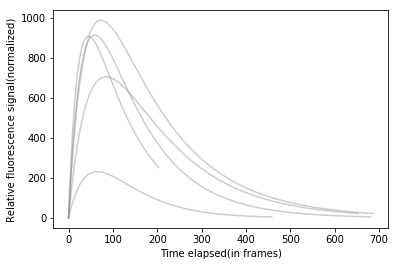

In [43]:
set1,set2,set3 = list(),list(),list()
for i in range(5):
    xdata = np.arange(0,int(500*np.random.normal(loc=1,scale=0.3)),1.)
    set1.append(400*np.random.normal(loc=5,scale=0.3))
    set2.append(30* np.random.normal(loc=4,scale=1))
    set3.append(10*np.random.normal(loc=4,scale=1))
    y = (alphaKernel(xdata,set1[i],set2[i],set3[i]))
    plt.plot(y,'grey',alpha=0.4)
plt.xlabel("Time elapsed(in frames)")
plt.ylabel("Relative fluorescence signal(normalized)")
plt.savefig('alphakernel')
print set1,set2,set3

1896.04114042 120.208700102 25.4247271856

In [70]:
filename = "/home/maximilian/unistuff/paris_ens/cal_neuroim/ADproject/Results.xls.~79~"
start = time.time()
dataMatrix = []
for line in open(filename):
    try:
        dataMatrix.append([float(number) for number in (line).split()])
    except(ValueError): 
        next
dataMatrix = np.matrix(dataMatrix)
print 'total time elapsed reading file:%f' % (time.time()-start), dataMatrix[10,10]

total time elapsed reading file:0.092461 586.298


In [68]:
start = time.time()
frame = pd.read_csv(filename,sep = "\t")
numOfRois = frame.shape[1]
dataMatrix = frame.as_matrix()
print 'total time elapsed reading file:%f' % (time.time()-start), dataMatrix[10,10]

total time elapsed reading file:0.042681 586.298


(5000, 47)